In [1]:
#place holders:
encoder1= 'bert-base-uncased'
encoder2= 'google/vit-base-patch16-224-in21k'
output_dir= "/kaggle/working/"
#hyperparameters
dropout_rate= 0.6
epochs= 15
batch_size= 32
learning_rate= 1e-4

In [2]:
base= "/kaggle/input/daquar-preprocessed/dataset"
fin= open(base + "/answer_space.txt")
answer_space= fin.read().splitlines()

In [3]:
import warnings
import os
warnings.filterwarnings('ignore')

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#os.environ['HF_HOME'] = os.path.join(".", "cache")

In [5]:
from IPython.display import HTML, FileLink
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [6]:
!pip install -U datasets==2.16.0 dataclasses -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
cudf 23.8.0 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.4.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.1.4 which is incompatible.
cudf

In [7]:
!pip install transformers peft trl bitsandbytes fsspec -q

In [8]:
!pip install accelerate -U -q

In [9]:
import numpy as np
import os
import random
import pickle
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Tuple

import sklearn.metrics
import torch
import torch.nn as nn
import nltk

import transformers
from transformers import AutoModel, AutoTokenizer, AutoFeatureExtractor
import datasets
from datasets import load_dataset
from dataclasses import dataclass

In [10]:
from nltk.corpus import wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [12]:
datasets.enable_caching()

In [13]:
def set_seed(seed: int = 906):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 906


In [14]:
dataset= load_dataset("csv",
                      data_files= {
                          "train": base+ "/data_train.csv",
                          "test" : base+ "/data_eval.csv"
                      }
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [15]:
dataset= dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0])
            for ans in examples['answer']
        ]
    },  batched= True
)

Map:   0%|          | 0/9974 [00:00<?, ? examples/s]

Map:   0%|          | 0/2494 [00:00<?, ? examples/s]

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 2494
    })
})

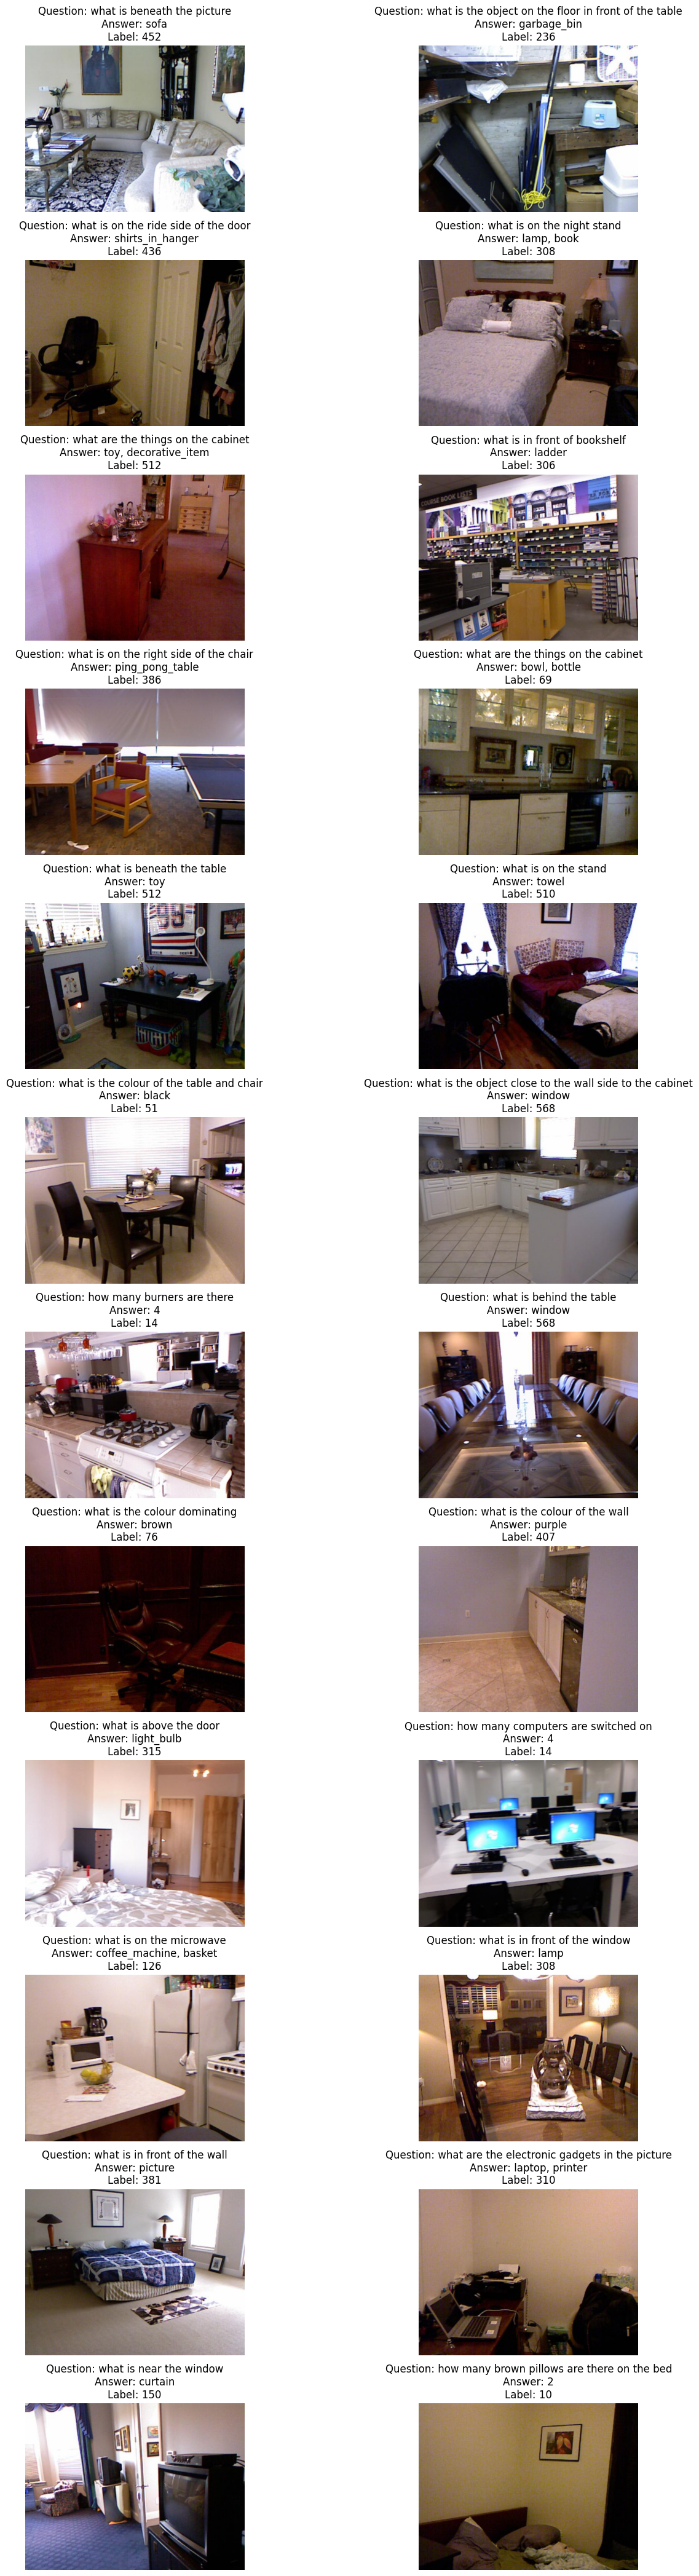

In [17]:
fig, axs= plt.subplots(12,2)
for i in range(12):
    x= random.randrange(dataset['train'].num_rows)
    img= plt.imread(base+"/images/"+dataset['train'][x]['image_id']+".png")
    plt.gcf().set_size_inches(18, 42)
    
    question= "Question: {}\n".format(dataset['train'][x]['question'])
    answer= "Answer: {}\n".format(dataset['train'][x]['answer'])
    label= "Label: {}".format(dataset['train'][x]['label'])
    title= question+ answer+ label
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(title)
    axs[i, 0].axis("off")
    
    x= random.randrange(dataset['train'].num_rows)
    img= plt.imread(base+"/images/"+dataset['train'][x]['image_id']+".png")
    question= "Question: {}\n".format(dataset['train'][x]['question'])
    answer= "Answer: {}\n".format(dataset['train'][x]['answer'])
    label= "Label: {}".format(dataset['train'][x]['label'])
    title= question+ answer+ label
    axs[i, 1].imshow(img)
    axs[i, 1].set_title(title)
    axs[i, 1].axis("off")

    fig.tight_layout(h_pad= 1, w_pad= 0.01)

plt.show()

In [18]:
@dataclass
class MergeCollators:
    def __init__(self, text_encoder, image_encoder):
        super(MergeCollators, self).__init__()
        self.tokenizer= text_encoder
        self.preprocesser= image_encoder

    def preprocess_texts(self, text: List[str]):
        preprocessed_text= self.tokenizer(
            text= text,
            padding= 'longest',
            max_length= 24,
            truncation= True,
            return_tensors= 'pt',
            return_token_type_ids= True,
            return_attention_mask= True
        )
        return {
            'input_ids': preprocessed_text['input_ids'].squeeze(),
            'token_type_ids': preprocessed_text['token_type_ids'].squeeze(),
            'attention_mask': preprocessed_text['attention_mask'].squeeze()
        }

    def preprocess_images(self, images: List[str]):
        preprocessed_images= self.preprocesser(
            images= [plt.imread(base+ '/images/'+ x+ '.png') for x in images],
            return_tensors= 'pt'
        )
        return {
            'pixel_values': preprocessed_images['pixel_values'].squeeze()
        }

    def __call__(self, batch_data):
        return {
            **self.preprocess_texts(
                batch_data['question']
                if isinstance(batch_data, dict) else
                [i['question'] for i in batch_data]
            ),
            **self.preprocess_images(
                batch_data['image_id']
                if isinstance(batch_data, dict)
                else [i['image_id'] for i in batch_data]
            ),
            'labels': torch.tensor(
                batch_data['label']
                if isinstance(batch_data, dict)
                else [i['label'] for i in batch_data],
                dtype= torch.int64
            )
        }

In [19]:
class VQA(nn.Module):
    def __init__(self, 
                 text_encoder_name= encoder1, 
                 image_encoder_name= encoder2,
                 num_labels= len(answer_space)):
        super(VQA, self).__init__()
        self.num_labels= num_labels
        self.text_encoder_name= text_encoder_name
        self.image_encoder_name= image_encoder_name
        self.text_encoder= AutoModel.from_pretrained(self.text_encoder_name)
        self.image_encoder= AutoModel.from_pretrained(self.image_encoder_name)
    
        # 768 + 768
        self.combine= nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size+ self.image_encoder.config.hidden_size, 1059),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.layer1= nn.Linear(1059, 1059)
        self.classifier= nn.Linear(1059, self.num_labels)
        self.criterion= nn.CrossEntropyLoss()

    def forward(self, input_ids, pixel_values, attention_mask, token_type_ids, labels: Optional[torch.LongTensor]= None):
        encoded_text= self.text_encoder(
            input_ids= input_ids,
            attention_mask= attention_mask,
            token_type_ids= token_type_ids,
            return_dict= True
        )
        encoded_image= self.image_encoder(
            pixel_values= pixel_values,
            return_dict= True
        )
        combined_output= self.combine(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output']
                ],
                dim= 1
            )
        )
        logits= self.classifier(combined_output)
        output= {'logits': logits}
        if labels is not None:
            loss= self.criterion(logits, labels)
            output['loss']= loss

        return output

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
text_encoder= encoder1
image_encoder= encoder2
tokenizer= AutoTokenizer.from_pretrained(text_encoder)
preprocessor= AutoFeatureExtractor.from_pretrained(image_encoder)

model= VQA(text_encoder, image_encoder)
collator= MergeCollators(tokenizer, preprocessor)
model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

2024-04-01 04:19:46.352474: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 04:19:46.352572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 04:19:46.505937: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

VQA(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [21]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a) 
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score 

def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

In [22]:
def compute_metrics(results: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels= results
    preds= logits.argmax(axis= -1)
    return {
          'wups': batch_wup_measure(labels, preds),
          'acc': sklearn.metrics.accuracy_score(labels, preds),
          'f1': sklearn.metrics.f1_score(labels, preds, average= 'macro')
      }

In [23]:
arguments= transformers.TrainingArguments(
    learning_rate= learning_rate,
    optim="paged_adamw_8bit",
    lr_scheduler_type= 'linear',
    warmup_steps= 1,
    warmup_ratio= 0.1,
    output_dir= output_dir,
    seed= 1142,
    evaluation_strategy= "epoch",
    eval_steps= 100,
    logging_strategy= "epoch",
    logging_steps= 100,
    save_strategy= "no",
    save_steps= 100,
    save_total_limit= 0,
    metric_for_best_model= "wups",
    per_device_train_batch_size= batch_size,
    per_device_eval_batch_size= batch_size,
    remove_unused_columns= False,
    num_train_epochs= epochs,
    fp16= True,
    dataloader_num_workers= 0,
    report_to= "none",
)
multi_trainer = transformers.Trainer(
    model,
    arguments,
    train_dataset= dataset['train'],
    eval_dataset= dataset['test'],
    data_collator= collator,
    compute_metrics= compute_metrics
)

In [24]:
history= multi_trainer.train()

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [25]:
history

TrainOutput(global_step=4680, training_loss=3.8736995077540732, metrics={'train_runtime': 7229.3319, 'train_samples_per_second': 20.695, 'train_steps_per_second': 0.647, 'total_flos': 0.0, 'train_loss': 3.8736995077540732, 'epoch': 15.0})

In [26]:
history_eval= multi_trainer.evaluate()

In [27]:
history_eval

{'eval_loss': 3.8554036617279053,
 'eval_wups': 0.2645369765317051,
 'eval_acc': 0.21251002405773858,
 'eval_f1': 0.01642035966339512,
 'eval_runtime': 88.4617,
 'eval_samples_per_second': 28.193,
 'eval_steps_per_second': 0.882,
 'epoch': 15.0}

In [28]:
PATH = "state_dict_model.pt"
torch.save(model.state_dict(), PATH)

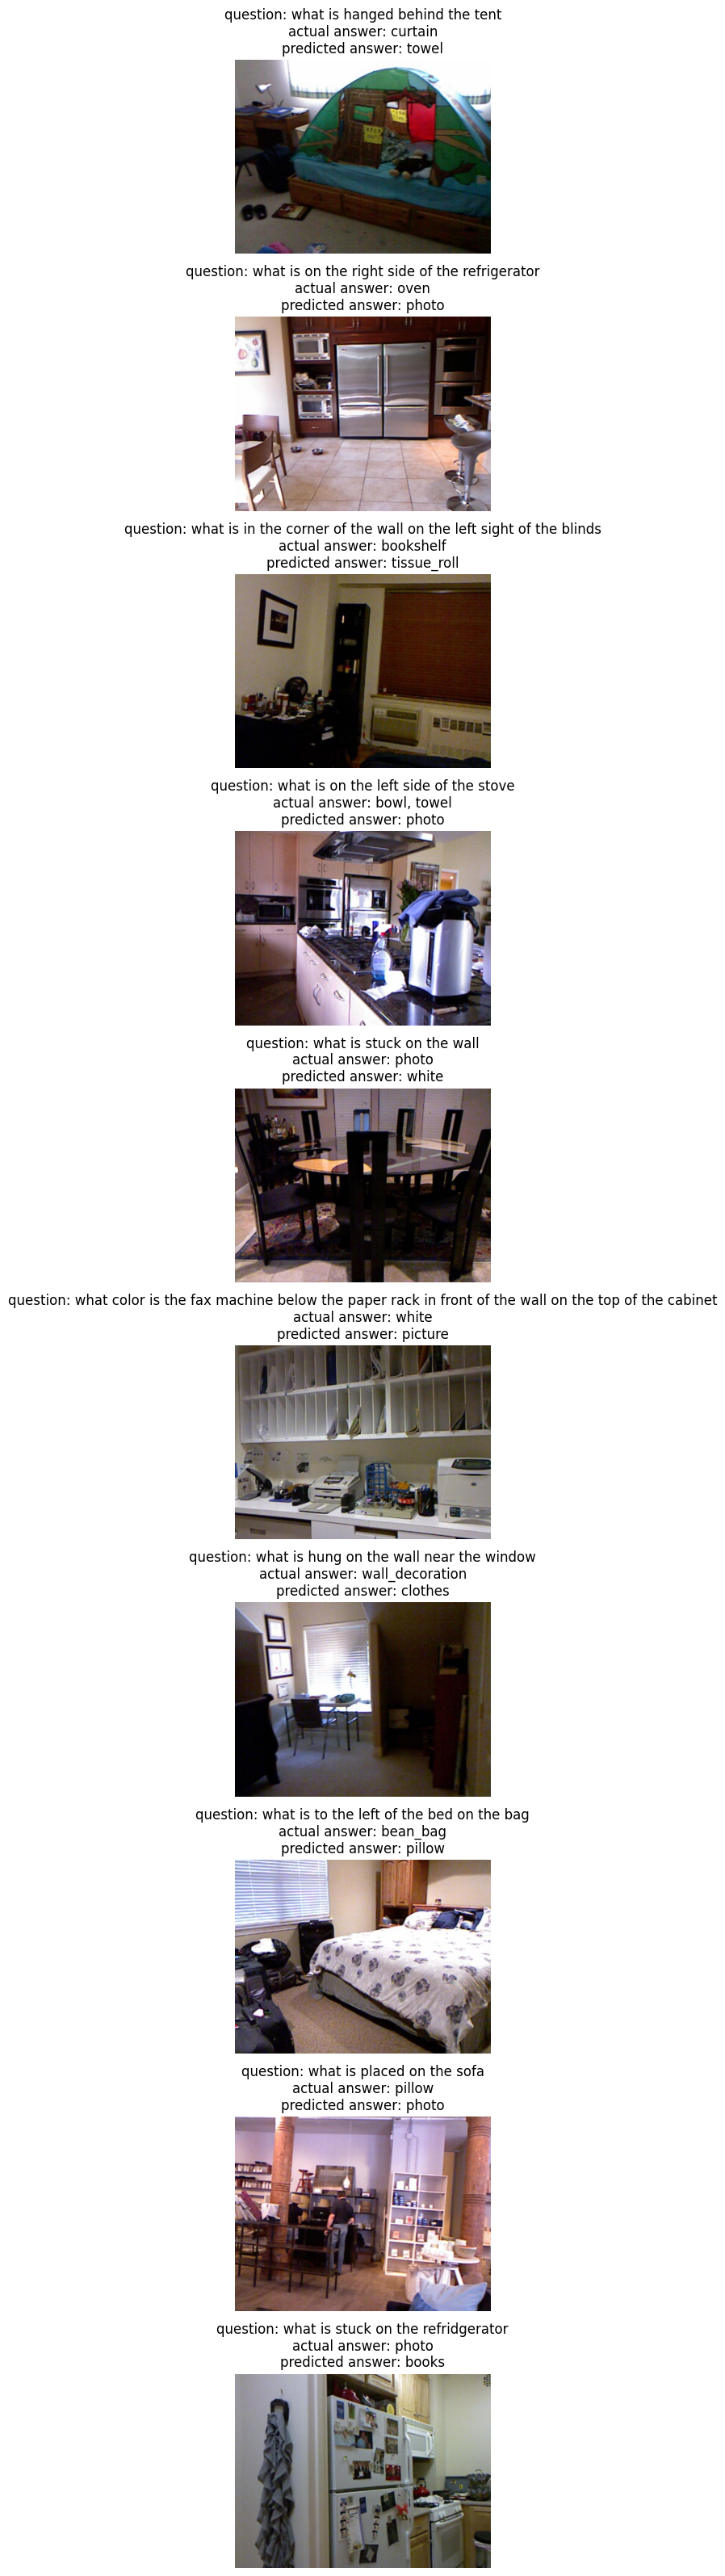

In [29]:
examples= 10
x= random.randrange(dataset['test'].num_rows-examples)
sample= collator(dataset['test'][x:x+examples])
      
input_ids= sample["input_ids"].to(device)
token_type_ids= sample["token_type_ids"].to(device)
attention_mask= sample["attention_mask"].to(device)
pixel_values= sample["pixel_values"].to(device)
labels= sample["labels"].to(device)

model.eval()
output= model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

preds= output["logits"].argmax(axis=-1).cpu().numpy()
fig= plt.figure(figsize=(32,32))
for i in range(examples):
    plt.subplot(examples,1,i+1)
    question= "question: {}".format(dataset['test'][(x-1)+i]['question'])
    answer= "actual answer: {}".format(dataset['test'][(x-1)+i]['answer'])
    pred_ans= "predicted answer: {}".format(answer_space[preds[i]])
    plt.imshow(plt.imread(base+"/images/"+dataset['test'][(x-1)+i]['image_id']+".png"))
    plt.axis("off")
    plt.title(question+"\n"+answer+"\n"+pred_ans)
    fig.tight_layout(h_pad= 1, w_pad= 0.01)
    
plt.show()    

In [30]:
with open('text-encoder.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol= pickle.HIGHEST_PROTOCOL)
with open('image-encoder.pickle', 'wb') as handle:
    pickle.dump(preprocessor, handle, protocol= pickle.HIGHEST_PROTOCOL)

In [31]:
FileLink(r'state_dict_model.pt')

/kaggle/working/state_dict_model.pt

In [32]:
FileLink('text-encoder.pickle')

/kaggle/working/text-encoder.pickle

In [33]:
FileLink('image-encoder.pickle')

/kaggle/working/image-encoder.pickle

In [34]:
def print_trainable_parameters(model):
    trainable_params= 0
    all_param= 0
    for _, param in model.named_parameters():
        all_param+= param.numel() 
        if param.requires_grad:
            trainable_params+= param.numel() 
    print("trainable params:", trainable_params) 
    print("all params:", all_param)
    print("trainable%:", (100 * trainable_params / all_param))
    
print_trainable_parameters(model)

trainable params: 199238631
all params: 199238631
trainable%: 100.0
